## Description:
Fits the Markstein-length model and estimates bootstrap uncertainty on the predicted $\tilde{S}_d^*$ outputs.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd

from flamekit.io_fronts import Case, load_fronts


### Read config file and define helper functions


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/Model_verification_uncertainty" / "Model_verification_uncertainty.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
TIME_STEPS = list(CFG["TIME_STEPS"])

PROGRESS_LEVELS = list(CFG["PROGRESS_LEVELS"])
POST = bool(CFG["POST"])
MULTIPLE_RUNS = bool(CFG["MULTIPLE_RUNS"])
N_RUN = int(CFG["N_RUN"])

CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])
CURVATURE_LOW = float(CFG["CURVATURE_LOW"])
CURVATURE_HIGH = float(CFG["CURVATURE_HIGH"])

T_REF = float(CFG.get("T_REF", 300.0))
TEMPERATURE_NONDIM = bool(CFG.get("TEMPERATURE_NONDIM", True))
C_CONSTANT = float(CFG.get("C_CONSTANT", 0.0))

N_POST_SAMPLES = int(CFG.get("N_POST_SAMPLES", 500))
PRIOR_ALPHA = float(CFG.get("PRIOR_ALPHA", 1e-6))
POSTERIOR_SEED = int(CFG.get("POSTERIOR_SEED", 42))
BAND_SIGMA = float(CFG.get("BAND_SIGMA", 1.0))
MAX_POINTS_FOR_BAND = int(CFG.get("MAX_POINTS_FOR_BAND", 2000))



SAVE_SPLITS = bool(CFG["SAVE_SPLITS"])
REPORT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUT_BASE_DIR"])

PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"


def time_dir(time_step: int) -> Path:
    return REPORT_BASE_DIR / PHI_TAG / LAT_TAG / f"t_{time_step}"


def case_out_dir(time_step: int, c_val: float | None = None, *parts: str) -> Path:
    out = time_dir(time_step)
    if c_val is not None and len(PROGRESS_LEVELS) > 1:
        out = out / f"T_{float(c_val):g}"
    for part in parts:
        out = out / part
    return out
LOW_FNAME_FMT = "curvature_le_{low:g}.csv"
HIGH_FNAME_FMT = "curvature_ge_{high:g}.csv"

if CURVATURE_LOW >= CURVATURE_HIGH:
    raise ValueError("CURVATURE_LOW must be < CURVATURE_HIGH")

# ============================================================
# PLOT STYLE (template-based)
# ============================================================
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

def save_multi_fig(fig, base: Path, suffix: str) -> None:
    out = base.with_name(f"{base.name}_{suffix}")
    fig.savefig(out.with_suffix(".png"), dpi=FIG_DPI)
    fig.savefig(out.with_suffix(".pdf"))
    fig.savefig(out.with_suffix(".svg"))

# ============================================================
# HELPERS
# ============================================================
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=DATA_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN
        )
    except TypeError:
        return Case(**base_kwargs)

def make_out_dir(time_step: int, c_val: float) -> Path:
    return case_out_dir(time_step, c_val)

def require_columns(df: pd.DataFrame, cols: list[str], context: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{context} Missing columns: {missing}")

def clean_valid_rows(df: pd.DataFrame, cols_needed: list[str]) -> pd.DataFrame:
    valid = df[cols_needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df.loc[valid.index].copy()

def split_by_curvature(df: pd.DataFrame, col: str, low: float, high: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    low_df = df[df[col] <= low].copy()
    high_df = df[df[col] >= high].copy()
    return low_df, high_df

def save_split(df: pd.DataFrame, savepath: Path | None, label: str) -> None:
    if savepath is None:
        return
    if df.empty:
        print(f"  {label}: skipped save (n=0)")
        return
    df.to_csv(savepath, index=False)



### Run


In [3]:
for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        require_columns(front, [CURVATURE_COLUMN], context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, [CURVATURE_COLUMN])

        low_df, high_df = split_by_curvature(dfv, CURVATURE_COLUMN, CURVATURE_LOW, CURVATURE_HIGH)
        print(
            f"t={t}, T={float(c_val):.2f}: n_total={len(dfv)}, n_low={len(low_df)}, n_high={len(high_df)}"
        )

        if SAVE_SPLITS:
            out_dir = make_out_dir(t, float(c_val))
            out_dir.mkdir(parents=True, exist_ok=True)
            low_path = out_dir / LOW_FNAME_FMT.format(low=CURVATURE_LOW)
            high_path = out_dir / HIGH_FNAME_FMT.format(high=CURVATURE_HIGH)
            save_split(low_df, low_path, "low")
            save_split(high_df, high_path, "high")


t=200, T=0.60: n_total=6491, n_low=1120, n_high=3011


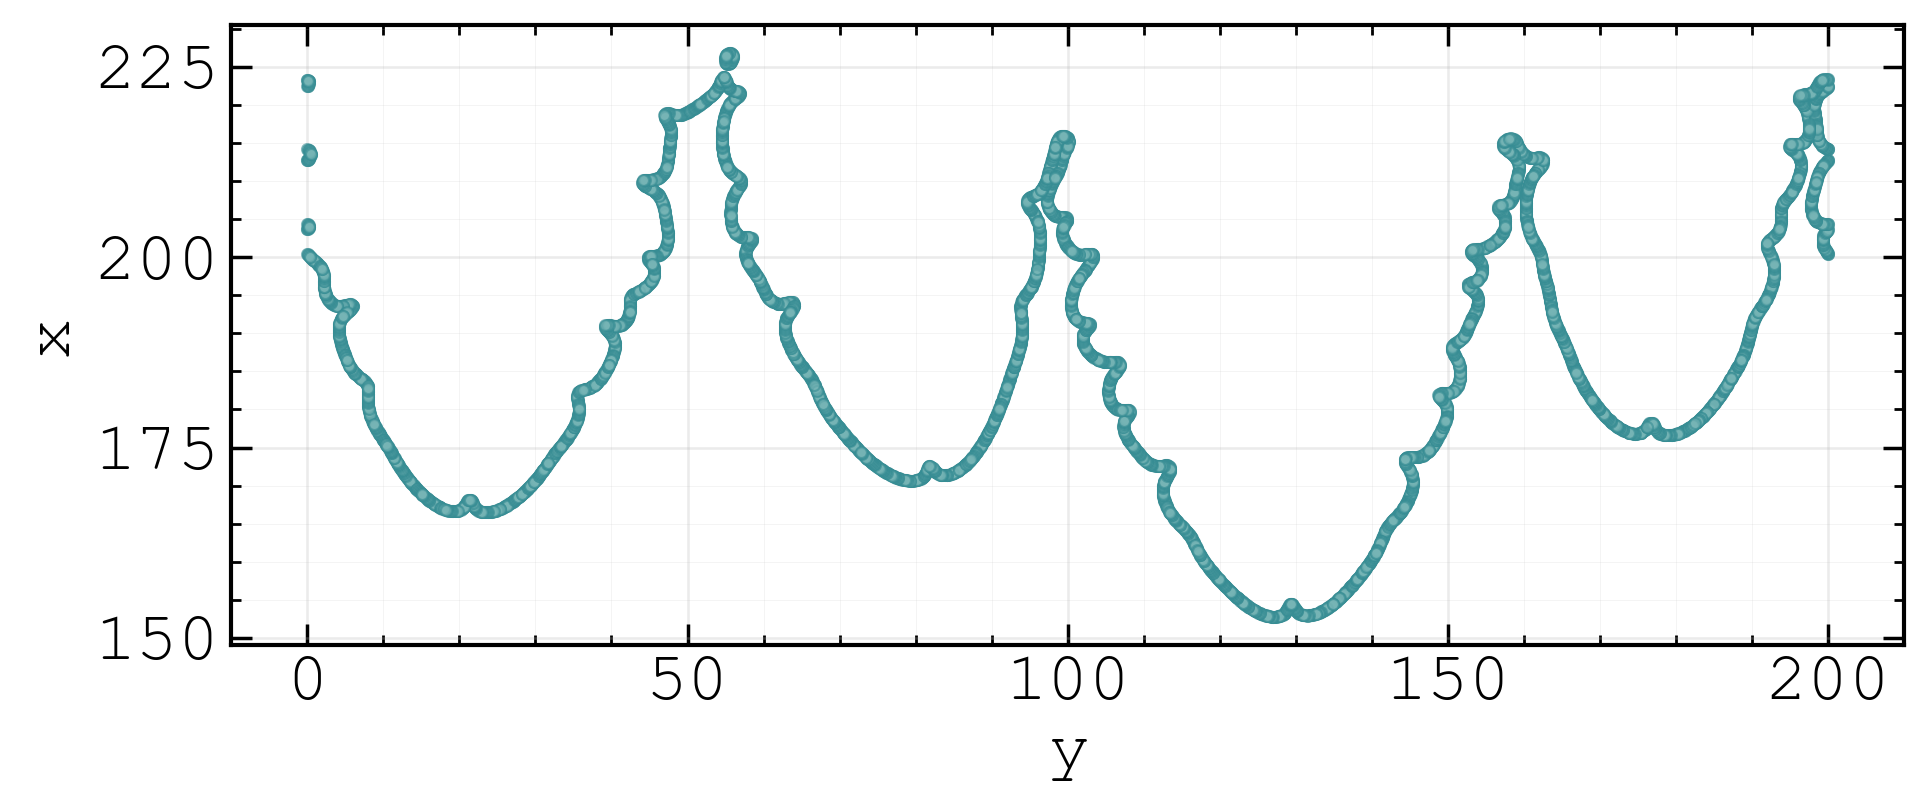

In [4]:
# Isocontour scatter plot (x vs y) before regressions
import matplotlib.pyplot as plt

SCATTER_S_ISO = 10
ALPHA_ISO = 0.6
SAVE_ISO_SCATTER = True
ISO_SCATTER_DIR = "isocontour_scatter"
ISO_FIG_SIZE = (7.6, 7.6)

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()
        require_columns(front, ["x", "y"], context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, ["x", "y"])

        fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            dfv["y"],
            dfv["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.6,
            zorder=3,
        )
        ax.set_xlabel("y")
        ax.set_ylabel("x")
        style_axes(ax, equal=True)

        savepath = None
        if SAVE_ISO_SCATTER:
            out_dir = case_out_dir(t, c_val, ISO_SCATTER_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            savepath = out_dir / "isocontour_scatter"
            fig.savefig(savepath.with_suffix(".png"), dpi=FIG_DPI, bbox_inches="tight")
            fig.savefig(savepath.with_suffix(".pdf"), bbox_inches="tight")
            fig.savefig(savepath.with_suffix(".svg"), bbox_inches="tight")

        plt.show()
        plt.close(fig)




### Stretch-strain curvature ratio vs Sd (all data)


In [5]:
# Fit Sd = 1 - L_curv * curvature - L_str * stretch_rate on positive-curvature group
TARGET_COLUMN = "DW_FDS"
STRETCH_COLUMN = "stretch_rate"

def fit_markstein_lengths(
    df: pd.DataFrame,
    curv_col: str,
    stretch_col: str,
    target_col: str,
) -> tuple[float, float, float, float]:
    X = df[[curv_col, stretch_col]].to_numpy()
    y_true = df[target_col].to_numpy()
    y_fit = 1.0 - y_true
    coef, *_ = np.linalg.lstsq(X, y_fit, rcond=None)
    y_pred = 1.0 - (X @ coef)
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return float(coef[0]), float(coef[1]), r2, rmse

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()


        l_curv, l_str, r2, rmse = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        print(
            f"t={t}, T={float(c_val):.2f}: Sd = 1 - {l_curv:.3e}*curvature - {l_str:.3e}*stretch_rate | R^2={r2:.3f}, RMSE={rmse:.3e}"
        )



t=200, T=0.60: Sd = 1 - -4.998e-01*curvature - -5.996e-02*stretch_rate | R^2=-0.374, RMSE=2.951e-01


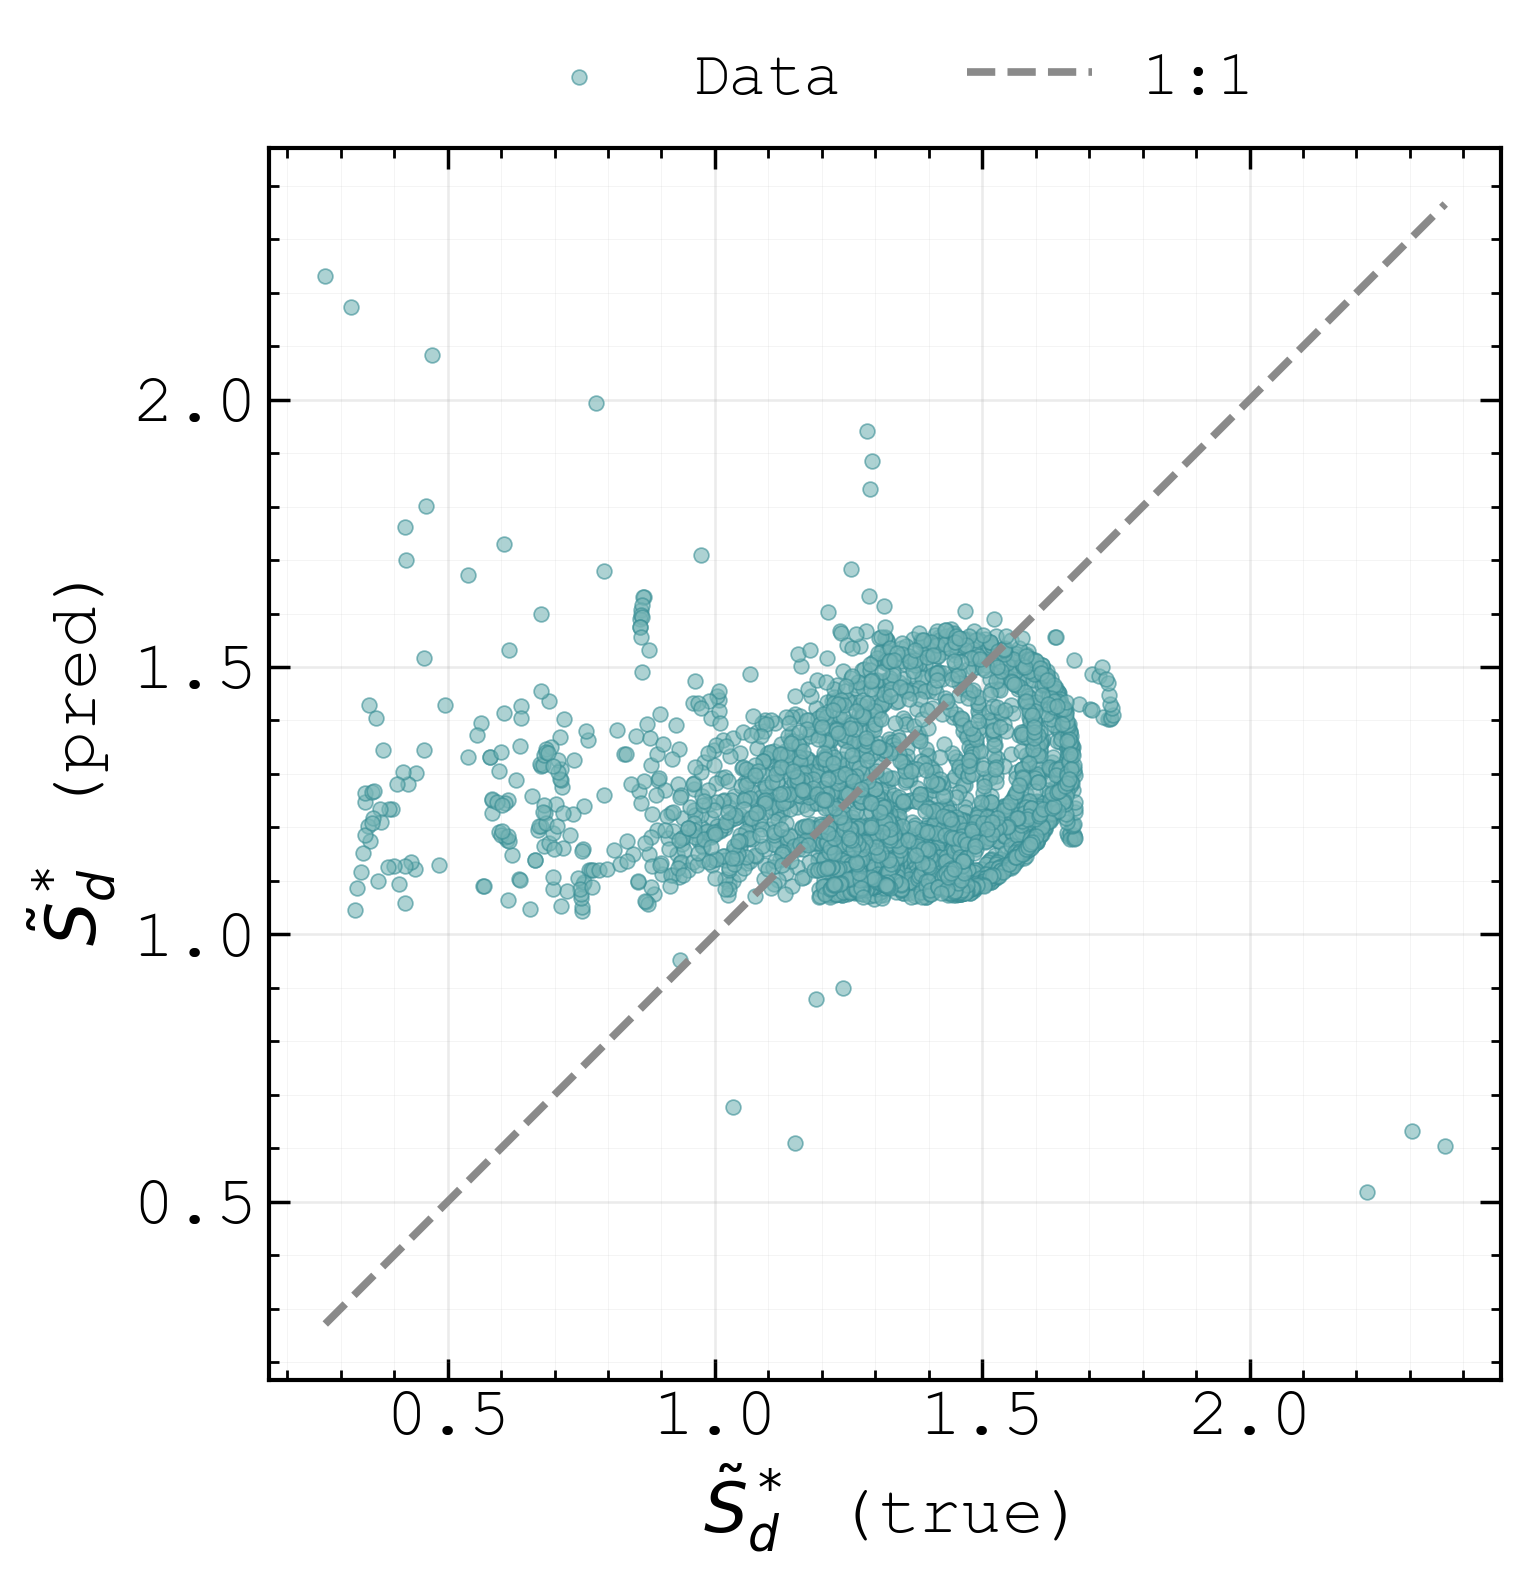

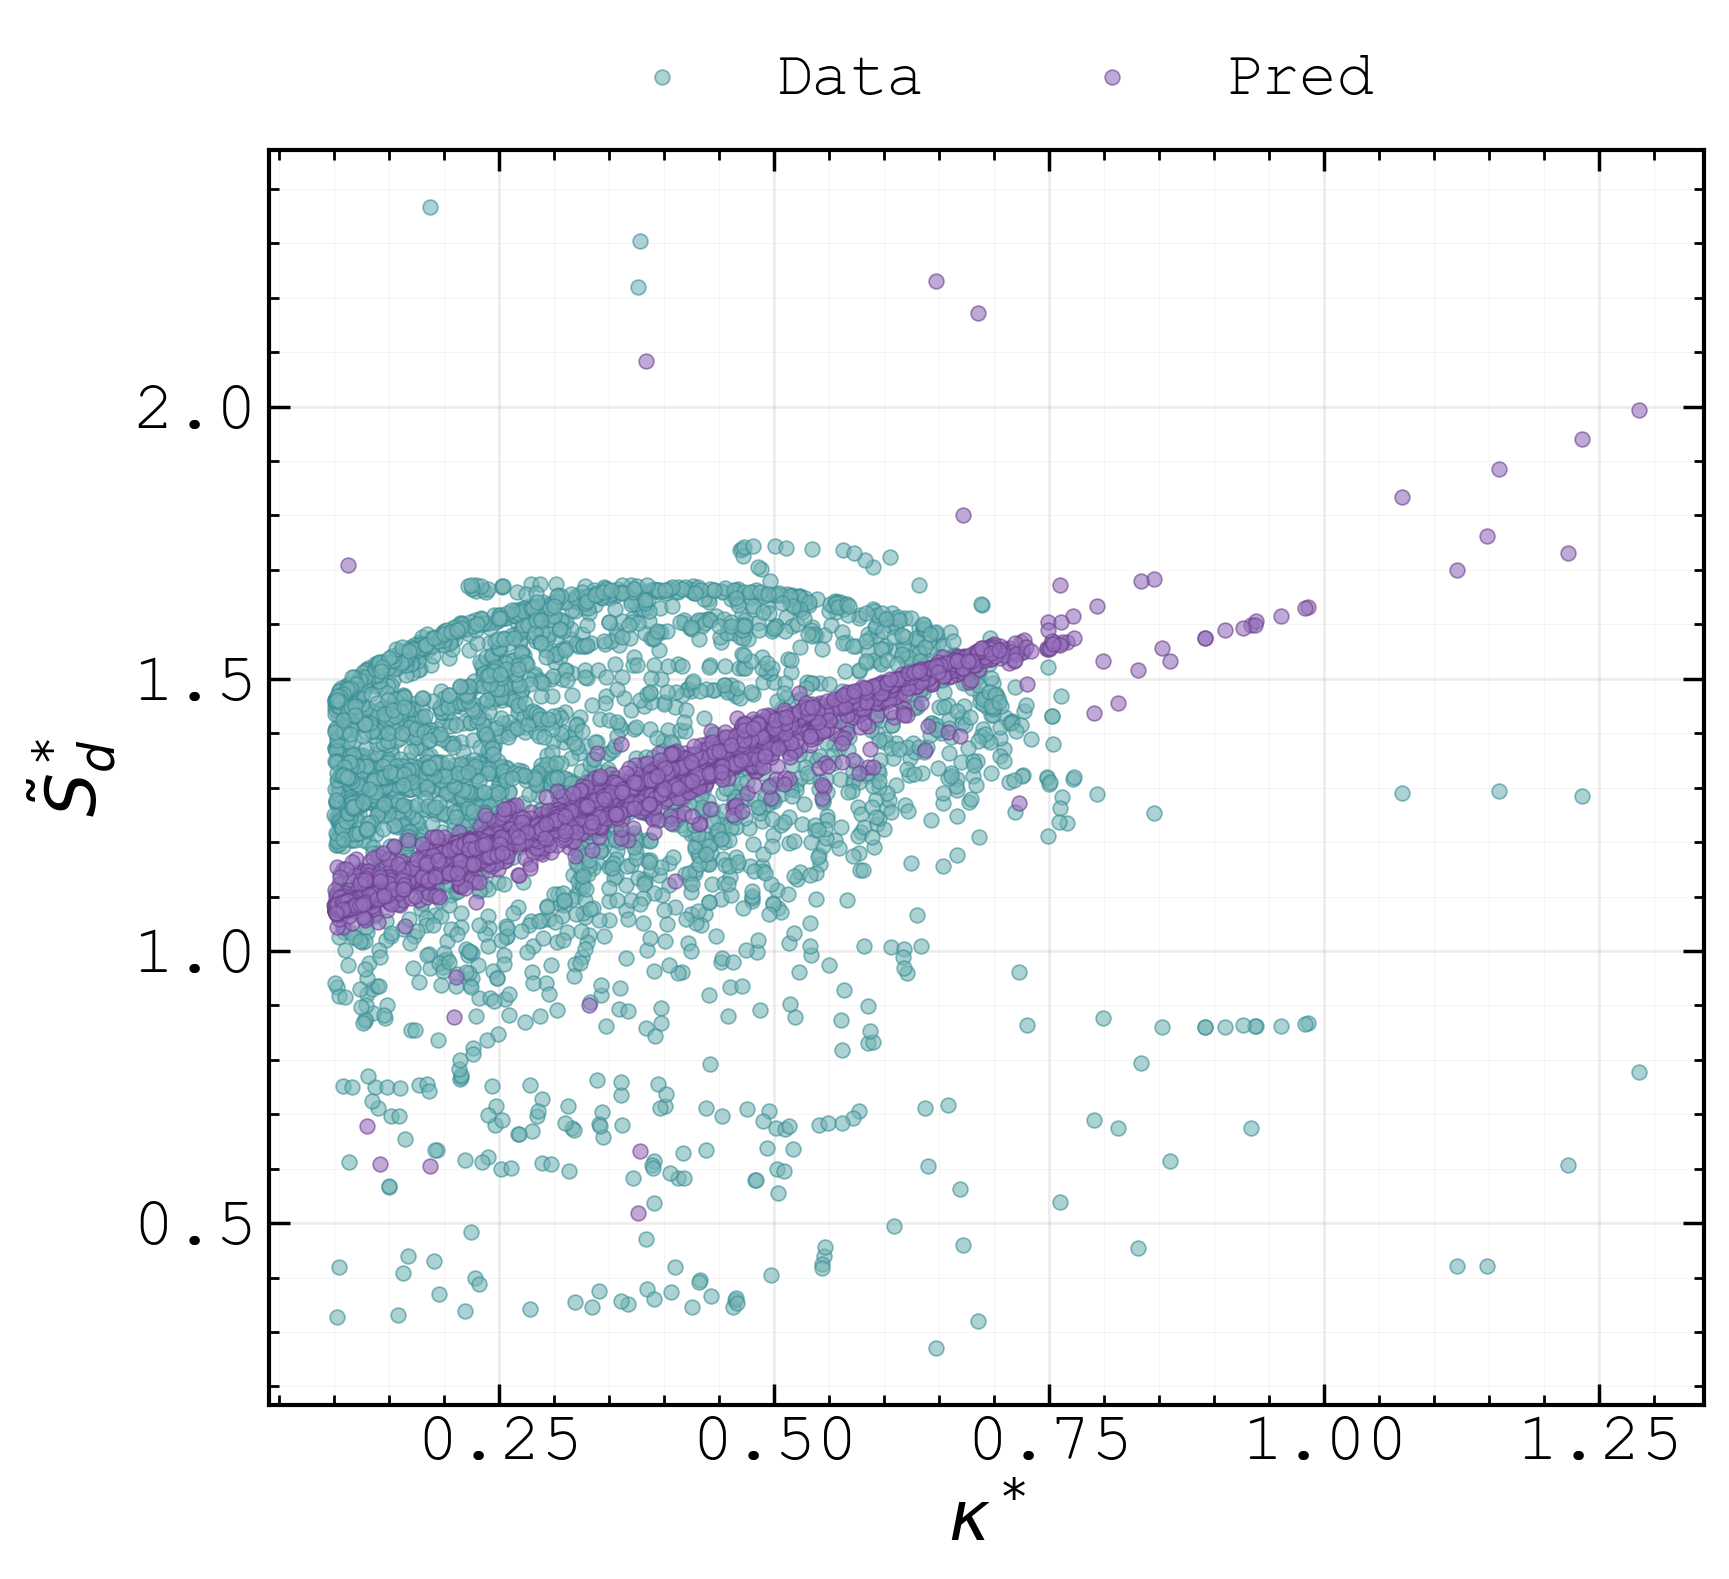

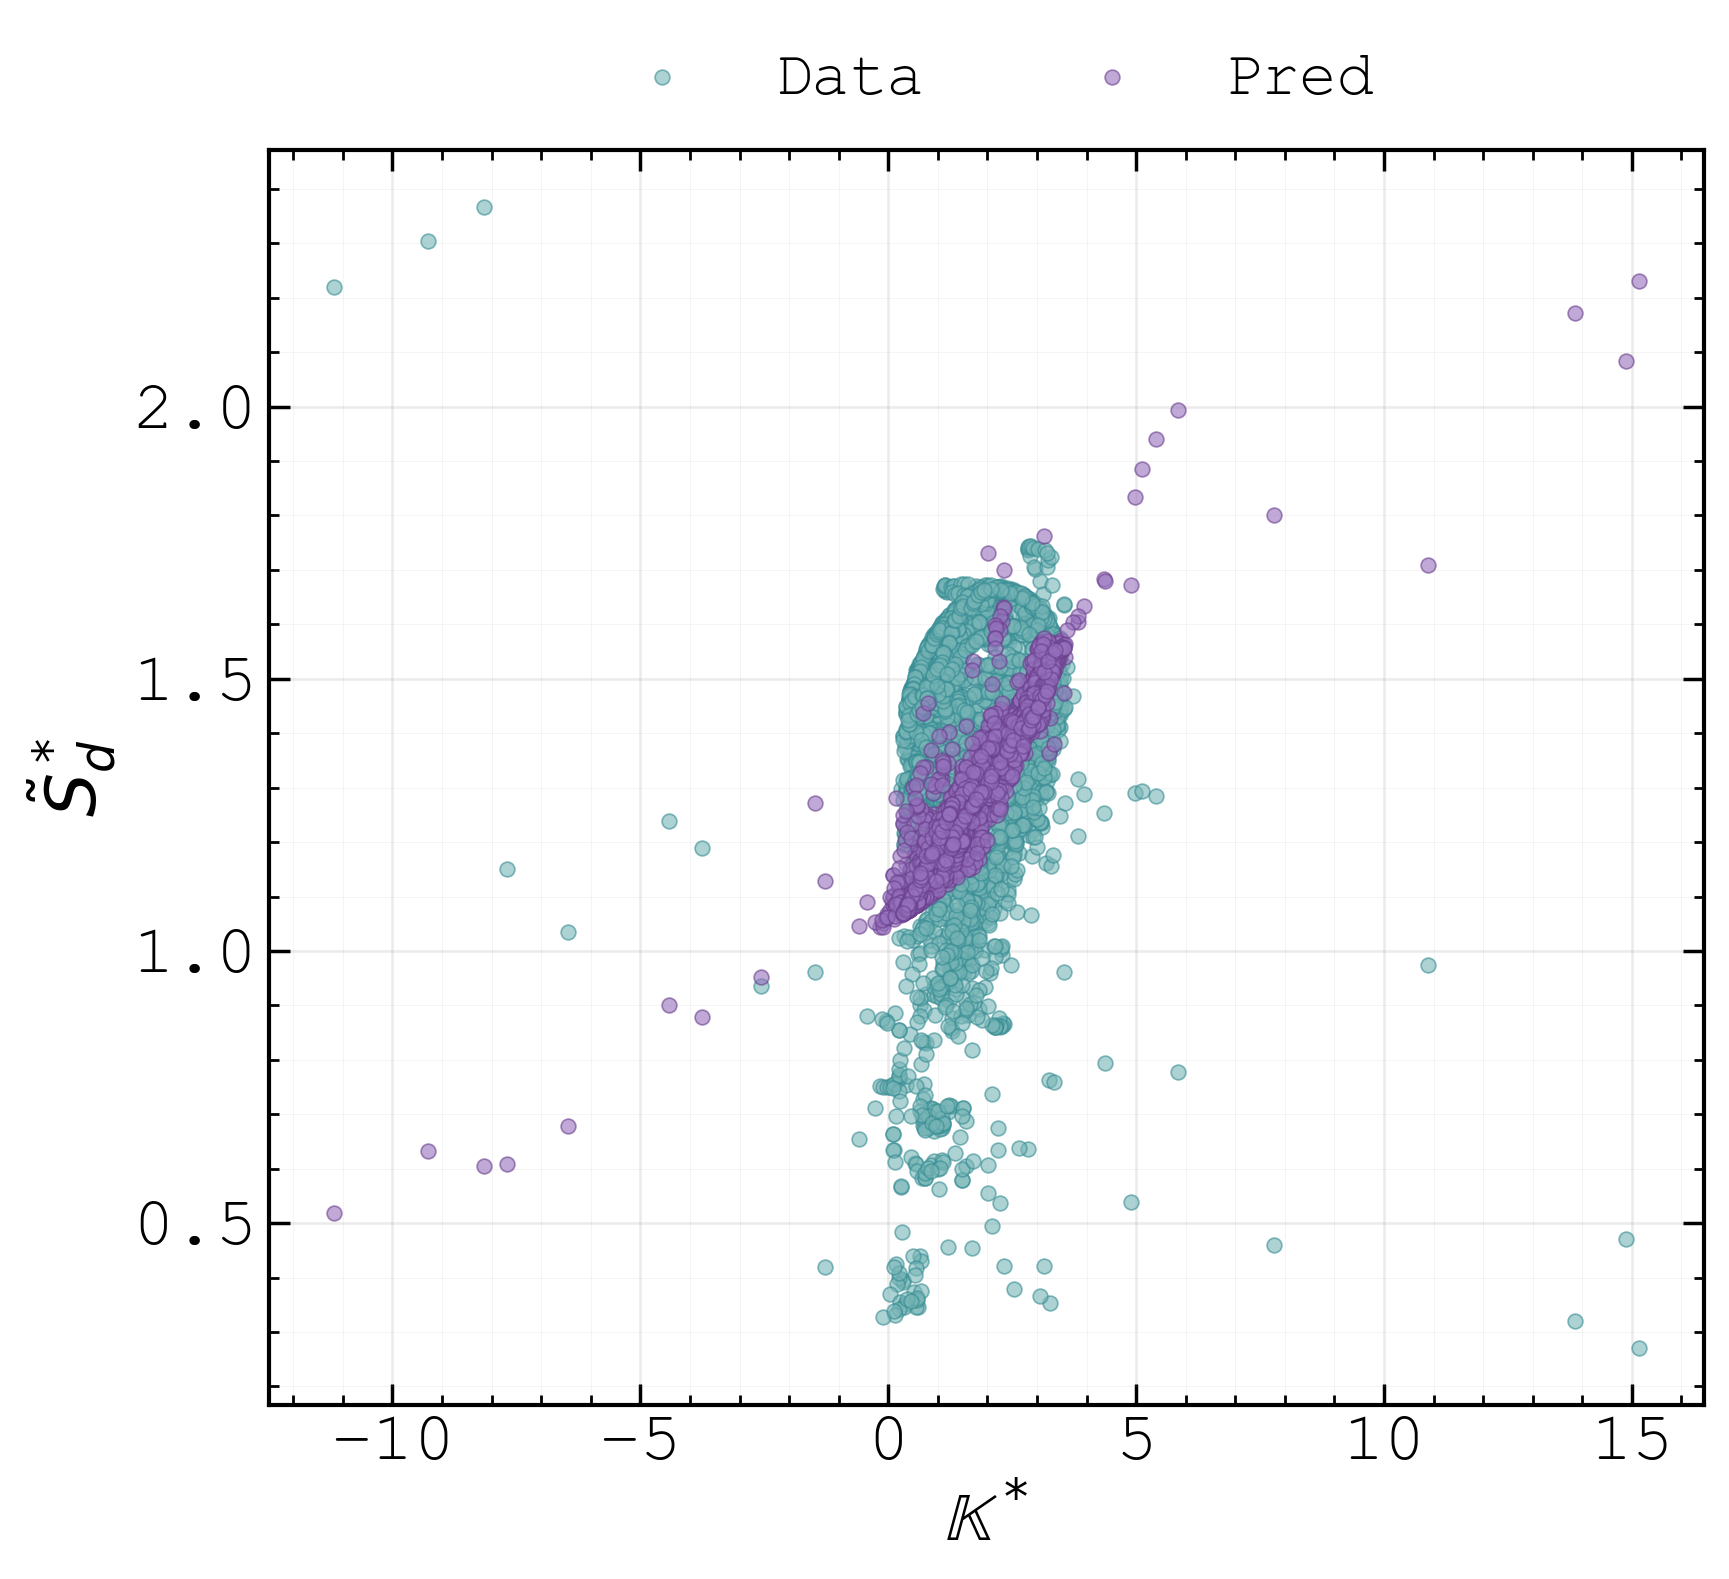

In [6]:
# Fit diagnostics plots for the positive-curvature group
import matplotlib.pyplot as plt

SAVE_FIT_PLOTS = True
FIT_OUT_DIR = "fit_plots"
DIAG_SCATTER_S = 18
DIAG_ALPHA = 0.6
LINE_WIDTH = 2.2
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)

def plot_fit_diagnostics(
    df: pd.DataFrame,
    l_curv: float,
    l_str: float,
    curv_col: str,
    stretch_col: str,
    target_col: str,
    savepath: Path | None = None,
) -> None:
    X = df[[curv_col, stretch_col]].to_numpy()
    y = df[target_col].to_numpy()
    y_pred = 1.0 - (X @ np.array([l_curv, l_str]))

    # (1) Predicted vs true
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        y,
        y_pred,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    lim_min = float(min(y.min(), y_pred.min()))
    lim_max = float(max(y.max(), y_pred.max()))
    ax.plot(
        [lim_min, lim_max],
        [lim_min, lim_max],
        linestyle="--",
        color=COLOR_LINE,
        linewidth=LINE_WIDTH,
        label="1:1",
    )
    ax.set_xlabel(f"{LABEL_SD} (true)")
    ax.set_ylabel(f"{LABEL_SD} (pred)")
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax, equal=True)
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        save_multi_fig(fig, savepath, "pred_vs_true")
    plt.show()
    plt.close(fig)

    # (2) Sd vs curvature with predictions at data points
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        df[curv_col],
        y,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    ax.scatter(
        df[curv_col],
        y_pred,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_PRED,
        edgecolors=COLOR_PRED_EDGE,
        linewidths=0.5,
        label="Pred",
    )
    ax.set_xlabel(LABEL_CURV)
    ax.set_ylabel(LABEL_SD)
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax)
    if savepath is not None:
        save_multi_fig(fig, savepath, "sd_vs_curvature")
    plt.show()
    plt.close(fig)

    # (3) Sd vs stretch rate with predictions at data points
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        df[stretch_col],
        y,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    ax.scatter(
        df[stretch_col],
        y_pred,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_PRED,
        edgecolors=COLOR_PRED_EDGE,
        linewidths=0.5,
        label="Pred",
    )
    ax.set_xlabel(LABEL_STRETCH)
    ax.set_ylabel(LABEL_SD)
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax)
    if savepath is not None:
        save_multi_fig(fig, savepath, "sd_vs_stretch")
    plt.show()
    plt.close(fig)

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()

        l_curv, l_str, _, _ = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        savepath = None
        if SAVE_FIT_PLOTS:
            out_dir = case_out_dir(t, c_val, FIT_OUT_DIR)
            savepath = out_dir / "fit_diagnostics"

        plot_fit_diagnostics(
            pos_df,
            l_curv=l_curv,
            l_str=l_str,
            curv_col=CURVATURE_COLUMN,
            stretch_col=STRETCH_COLUMN,
            target_col=TARGET_COLUMN,
            savepath=savepath,
        )








### Posterior weight uncertainty (sampled bands)


t=200, T=0.60: L_curv=-4.998e-01, L_str=-5.996e-02, noise_var=1.220e+02


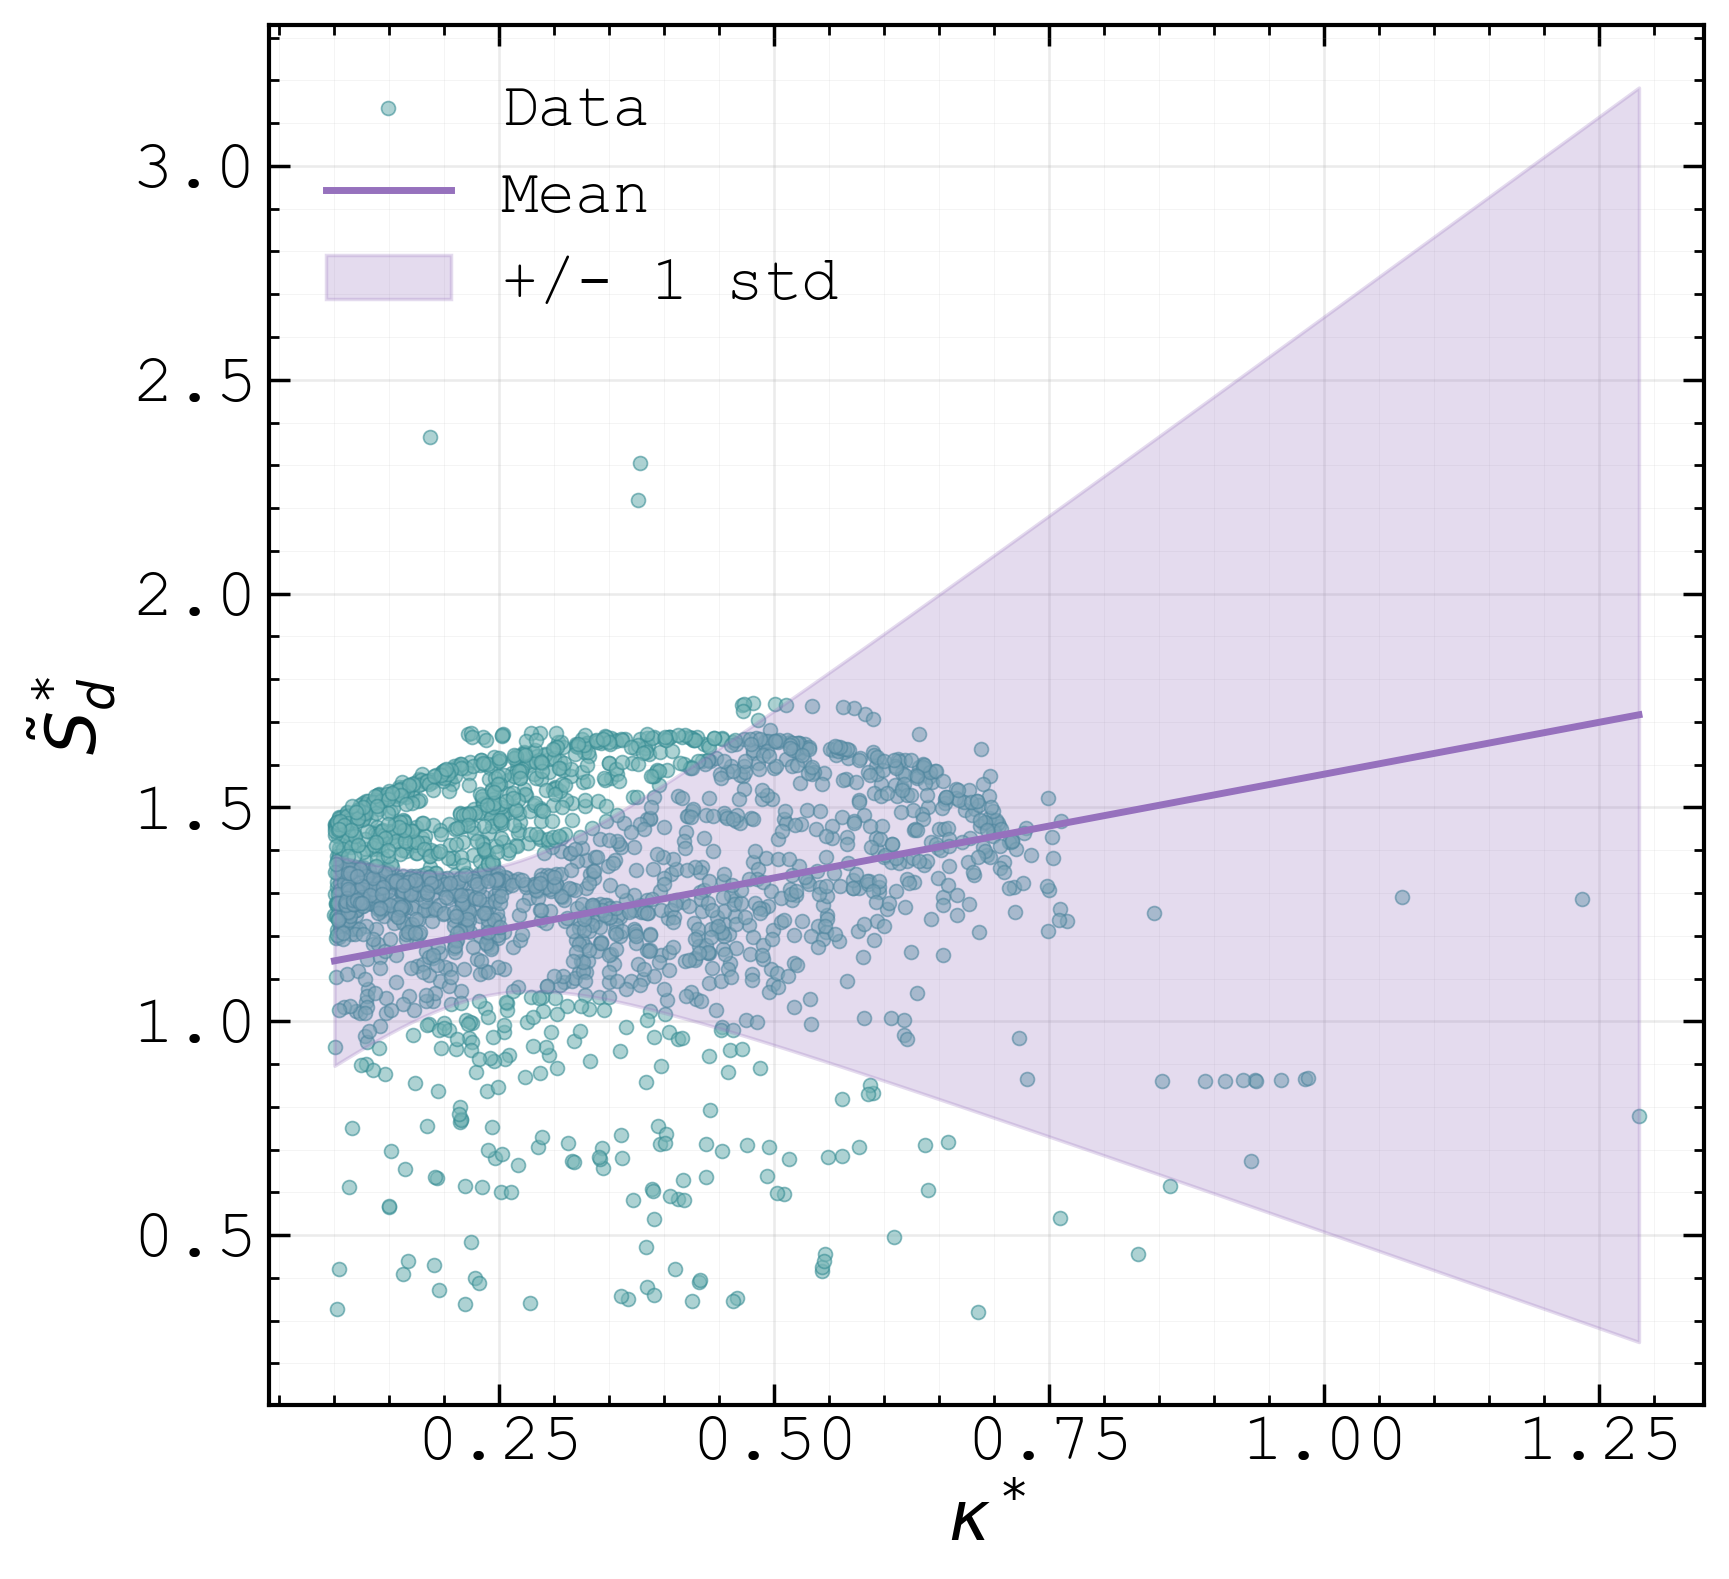

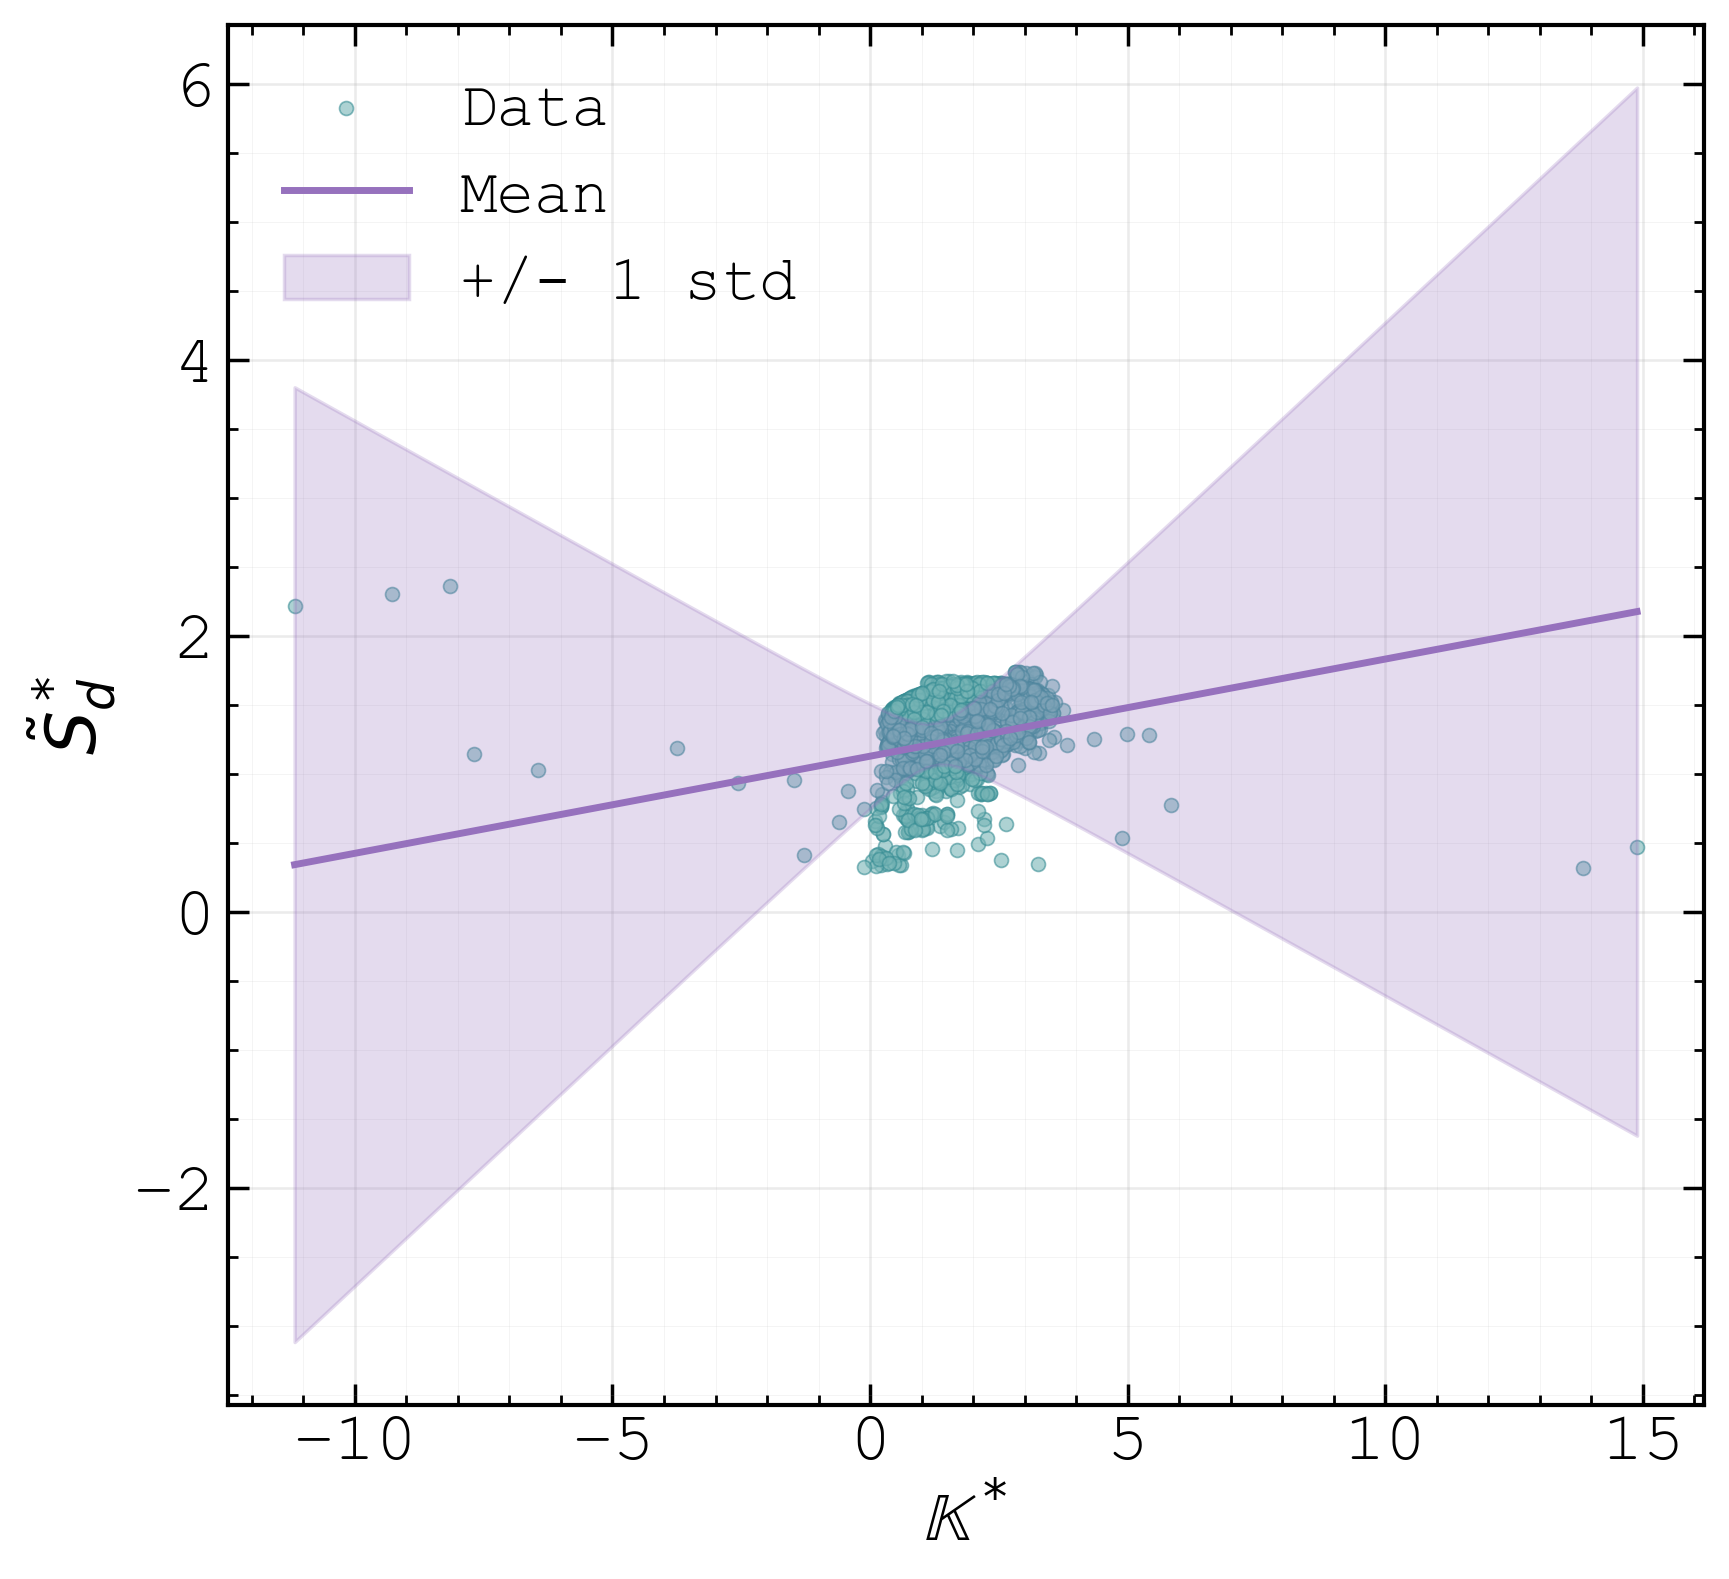

In [8]:
# Posterior sampling for the positive-curvature model
import matplotlib.pyplot as plt

SAVE_POSTERIOR_PLOTS = True
POSTERIOR_OUT_DIR = "posterior_plots"
POST_SCATTER_S = 16
POST_ALPHA = 0.6
BAND_ALPHA = 0.25
POST_LINE_WIDTH = 2.0

def bayes_posterior_weights(
    X: np.ndarray,
    y: np.ndarray,
    prior_alpha: float,
) -> tuple[np.ndarray, np.ndarray, float]:
    n, d = X.shape
    xtx = X.T @ X
    xty = X.T @ y
    w_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
    resid = y - X @ w_hat
    noise_var = float(np.var(resid, ddof=max(n - d, 1)))
    if noise_var <= 0.0 or not np.isfinite(noise_var):
        noise_var = 1e-12
    prior_prec = prior_alpha * np.eye(d)
    post_prec = prior_prec + xtx / noise_var
    post_cov = np.linalg.inv(post_prec)
    post_mean = post_cov @ (xty / noise_var)
    return post_mean, post_cov, noise_var

def sample_weights(
    mean: np.ndarray,
    cov: np.ndarray,
    n_samples: int,
    rng: np.random.Generator,
) -> np.ndarray:
    return rng.multivariate_normal(mean, cov, size=n_samples)

def plot_band(
    x: np.ndarray,
    y_mean: np.ndarray,
    y_std: np.ndarray,
    x_label: str,
    y_label: str,
    data_x: np.ndarray | None = None,
    data_y: np.ndarray | None = None,
    savepath: Path | None = None,
) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    if data_x is not None and data_y is not None:
        ax.scatter(
            data_x,
            data_y,
            s=POST_SCATTER_S,
            alpha=POST_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
    ax.plot(
        x,
        y_mean,
        color=COLOR_PRED,
        linewidth=POST_LINE_WIDTH,
        label="Mean",
    )
    ax.fill_between(
        x,
        y_mean - BAND_SIGMA * y_std,
        y_mean + BAND_SIGMA * y_std,
        color=COLOR_PRED,
        alpha=BAND_ALPHA,
        label=f"+/- {BAND_SIGMA:g} std",
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(frameon=False, fontsize=PLOT_FONT_SIZE - 2)
    style_axes(ax)
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        save_multi_fig(fig, savepath, "band")
    plt.show()
    plt.close(fig)

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        if len(pos_df) < 5:
            print(
                f"t={t}, T={float(c_val):.2f}: insufficient data for posterior (n={len(pos_df)})"
            )
            continue

        seed = POSTERIOR_SEED + int(t) * 1000 + int(float(c_val) * 100)
        rng = np.random.default_rng(seed)

        X = pos_df[[CURVATURE_COLUMN, STRETCH_COLUMN]].to_numpy()
        y_true = pos_df[TARGET_COLUMN].to_numpy()
        y_fit = 1.0 - y_true

        post_mean, post_cov, noise_var = bayes_posterior_weights(
            X,
            y_fit,
            prior_alpha=PRIOR_ALPHA,
        )
        w_samples = sample_weights(post_mean, post_cov, N_POST_SAMPLES, rng)
        print(
            f"t={t}, T={float(c_val):.2f}: "
            f"L_curv={post_mean[0]:.3e}, L_str={post_mean[1]:.3e}, "
            f"noise_var={noise_var:.3e}"
        )

        plot_df = pos_df
        if len(plot_df) > MAX_POINTS_FOR_BAND:
            plot_df = plot_df.sample(MAX_POINTS_FOR_BAND, random_state=seed)

        curv = plot_df[CURVATURE_COLUMN].to_numpy()
        stretch = plot_df[STRETCH_COLUMN].to_numpy()
        sd = plot_df[TARGET_COLUMN].to_numpy()

        curv_grid = np.linspace(float(curv.min()), float(curv.max()), 120)
        stretch_grid = np.linspace(float(stretch.min()), float(stretch.max()), 120)

        stretch_fixed = float(np.median(stretch))
        X_curv = np.column_stack([curv_grid, np.full_like(curv_grid, stretch_fixed)])
        sd_samples = 1.0 - X_curv @ w_samples.T
        sd_mean = sd_samples.mean(axis=1)
        sd_std = sd_samples.std(axis=1)

        savepath = None
        if SAVE_POSTERIOR_PLOTS:
            out_dir = case_out_dir(t, c_val, POSTERIOR_OUT_DIR)
            savepath = out_dir / "sd_vs_curvature_posterior"

        plot_band(
            curv_grid,
            sd_mean,
            sd_std,
            x_label=LABEL_CURV,
            y_label=LABEL_SD,
            data_x=curv,
            data_y=sd,
            savepath=savepath,
        )

        curv_fixed = float(np.median(curv))
        X_stretch = np.column_stack([np.full_like(stretch_grid, curv_fixed), stretch_grid])
        sd_samples = 1.0 - X_stretch @ w_samples.T
        sd_mean = sd_samples.mean(axis=1)
        sd_std = sd_samples.std(axis=1)

        savepath = None
        if SAVE_POSTERIOR_PLOTS:
            out_dir = case_out_dir(t, c_val, POSTERIOR_OUT_DIR)
            savepath = out_dir / "sd_vs_stretch_posterior"

        plot_band(
            stretch_grid,
            sd_mean,
            sd_std,
            x_label=LABEL_STRETCH,
            y_label=LABEL_SD,
            data_x=stretch,
            data_y=sd,
            savepath=savepath,
        )


In [9]:
# Negative-curvature model check: Sd = 1 - (1/T) * curvature * alpha * (1+C) / (S_L * L_ref)
TARGET_COLUMN = "DW_FDS"
TEMP_COLUMN = "T"
THERMAL_DIFF_COLUMN = "thermal_diffusivity"
S_L_COLUMN = "S_L"
L_REF_COLUMN = "L_ref"

def fit_c_constant(df: pd.DataFrame) -> tuple[float, np.ndarray, float, float]:
    temp = df[TEMP_COLUMN].to_numpy()
    curv = df[CURVATURE_COLUMN].to_numpy()
    alpha = df[THERMAL_DIFF_COLUMN].to_numpy()
    s_l = float(df[S_L_COLUMN].iloc[0])
    l_ref = float(df[L_REF_COLUMN].iloc[0])
    denom = temp * s_l * l_ref
    a = (curv * alpha) / denom
    y_true = df[TARGET_COLUMN].to_numpy()
    y_fit = 1.0 - y_true
    den = float(np.dot(a, a))
    if den <= 0.0:
        raise ValueError("Invalid fit: zero denominator for C regression")
    m = float(np.dot(a, y_fit) / den)
    c_est = m - 1.0
    y_pred = 1.0 - a * m
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return c_est, y_pred, r2, rmse

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, TEMP_COLUMN, THERMAL_DIFF_COLUMN, S_L_COLUMN, L_REF_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()


        c_est, y_pred, r2, rmse = fit_c_constant(neg_df)
        print(
            f"t={t}, T={float(c_val):.2f}: C={c_est:.3e}, R^2={r2:.3f}, RMSE={rmse:.3e}"
        )


t=200, T=0.60: C=-3.923e-01, R^2=0.563, RMSE=2.864e-01


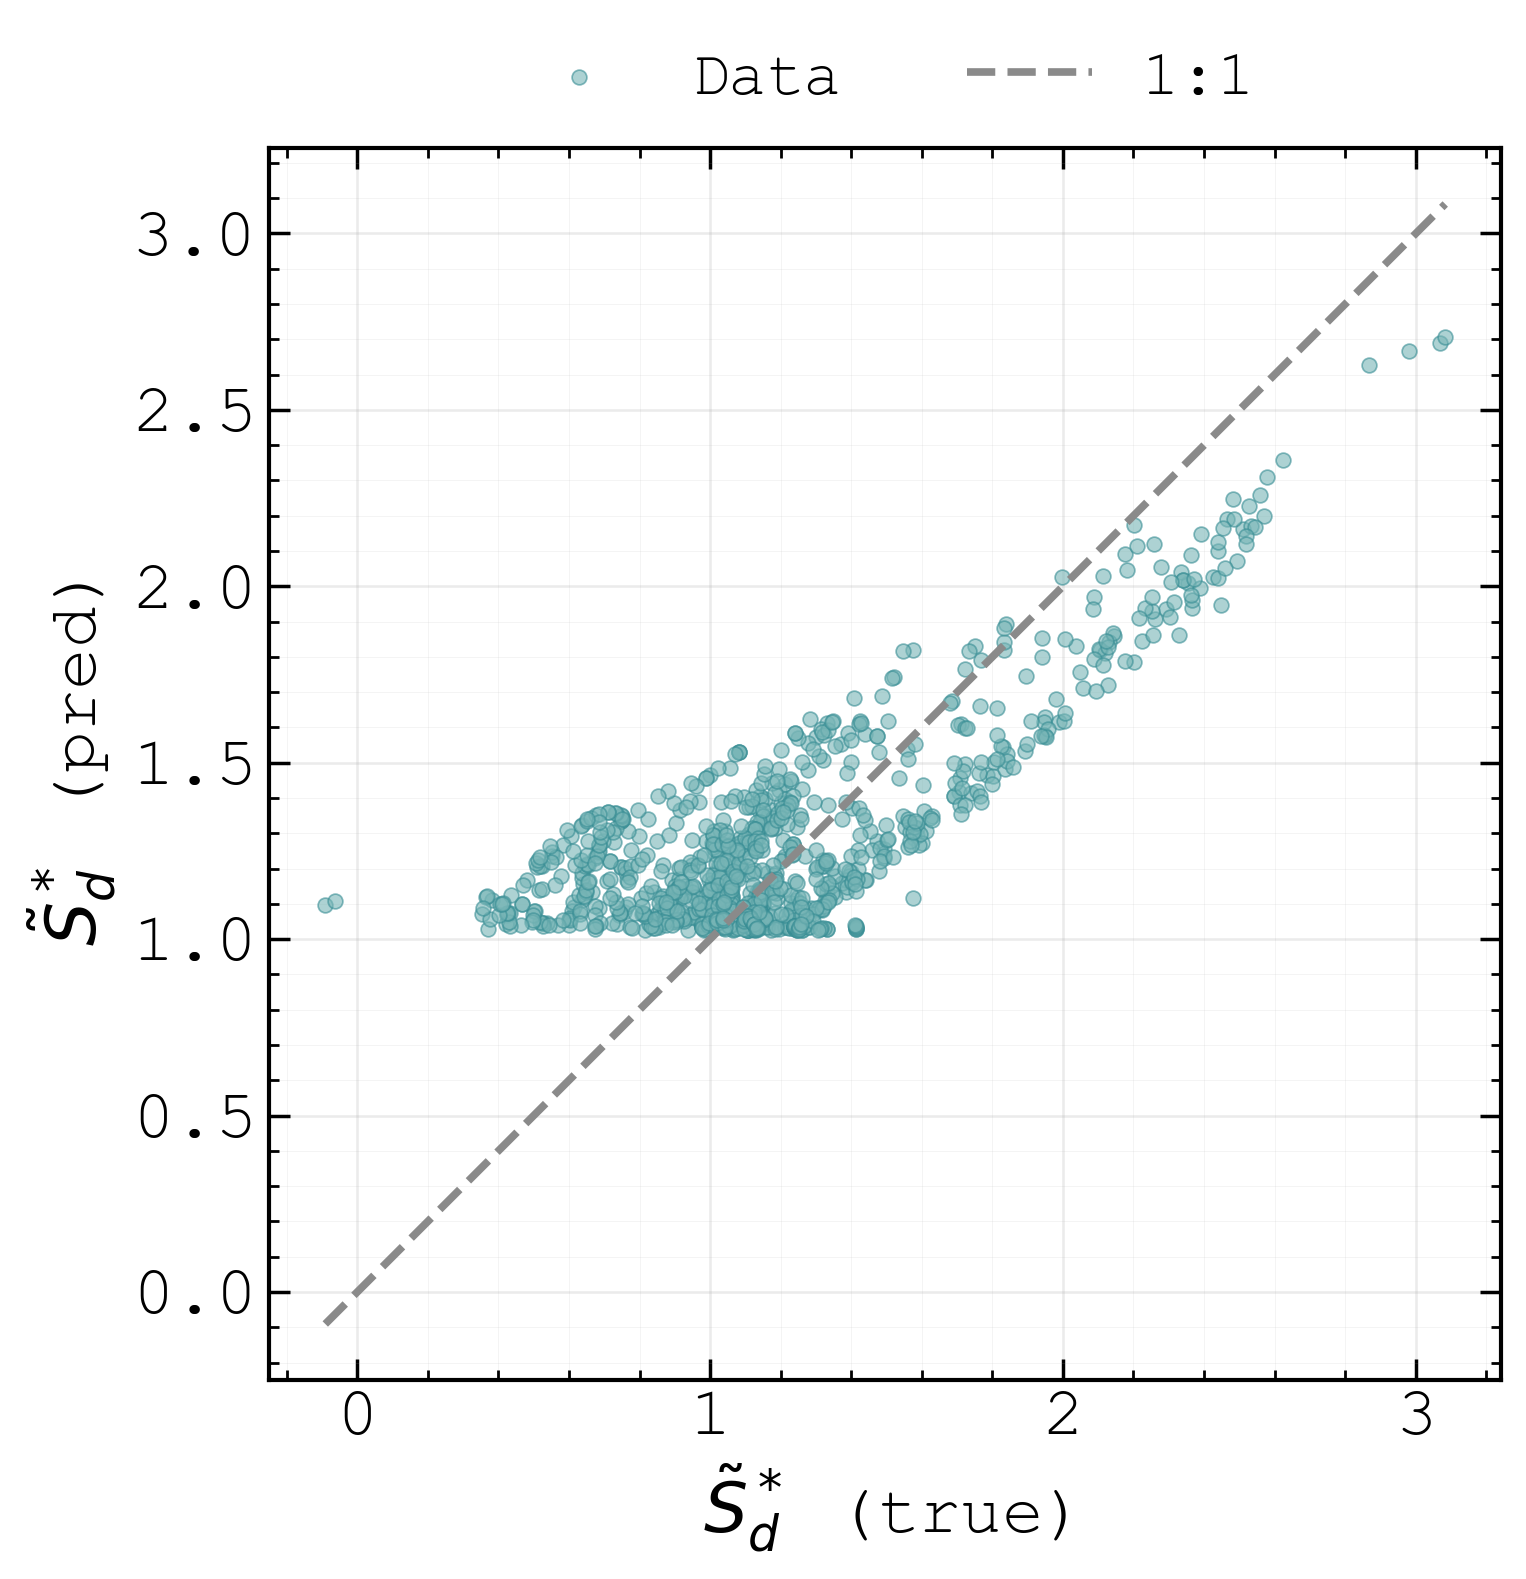

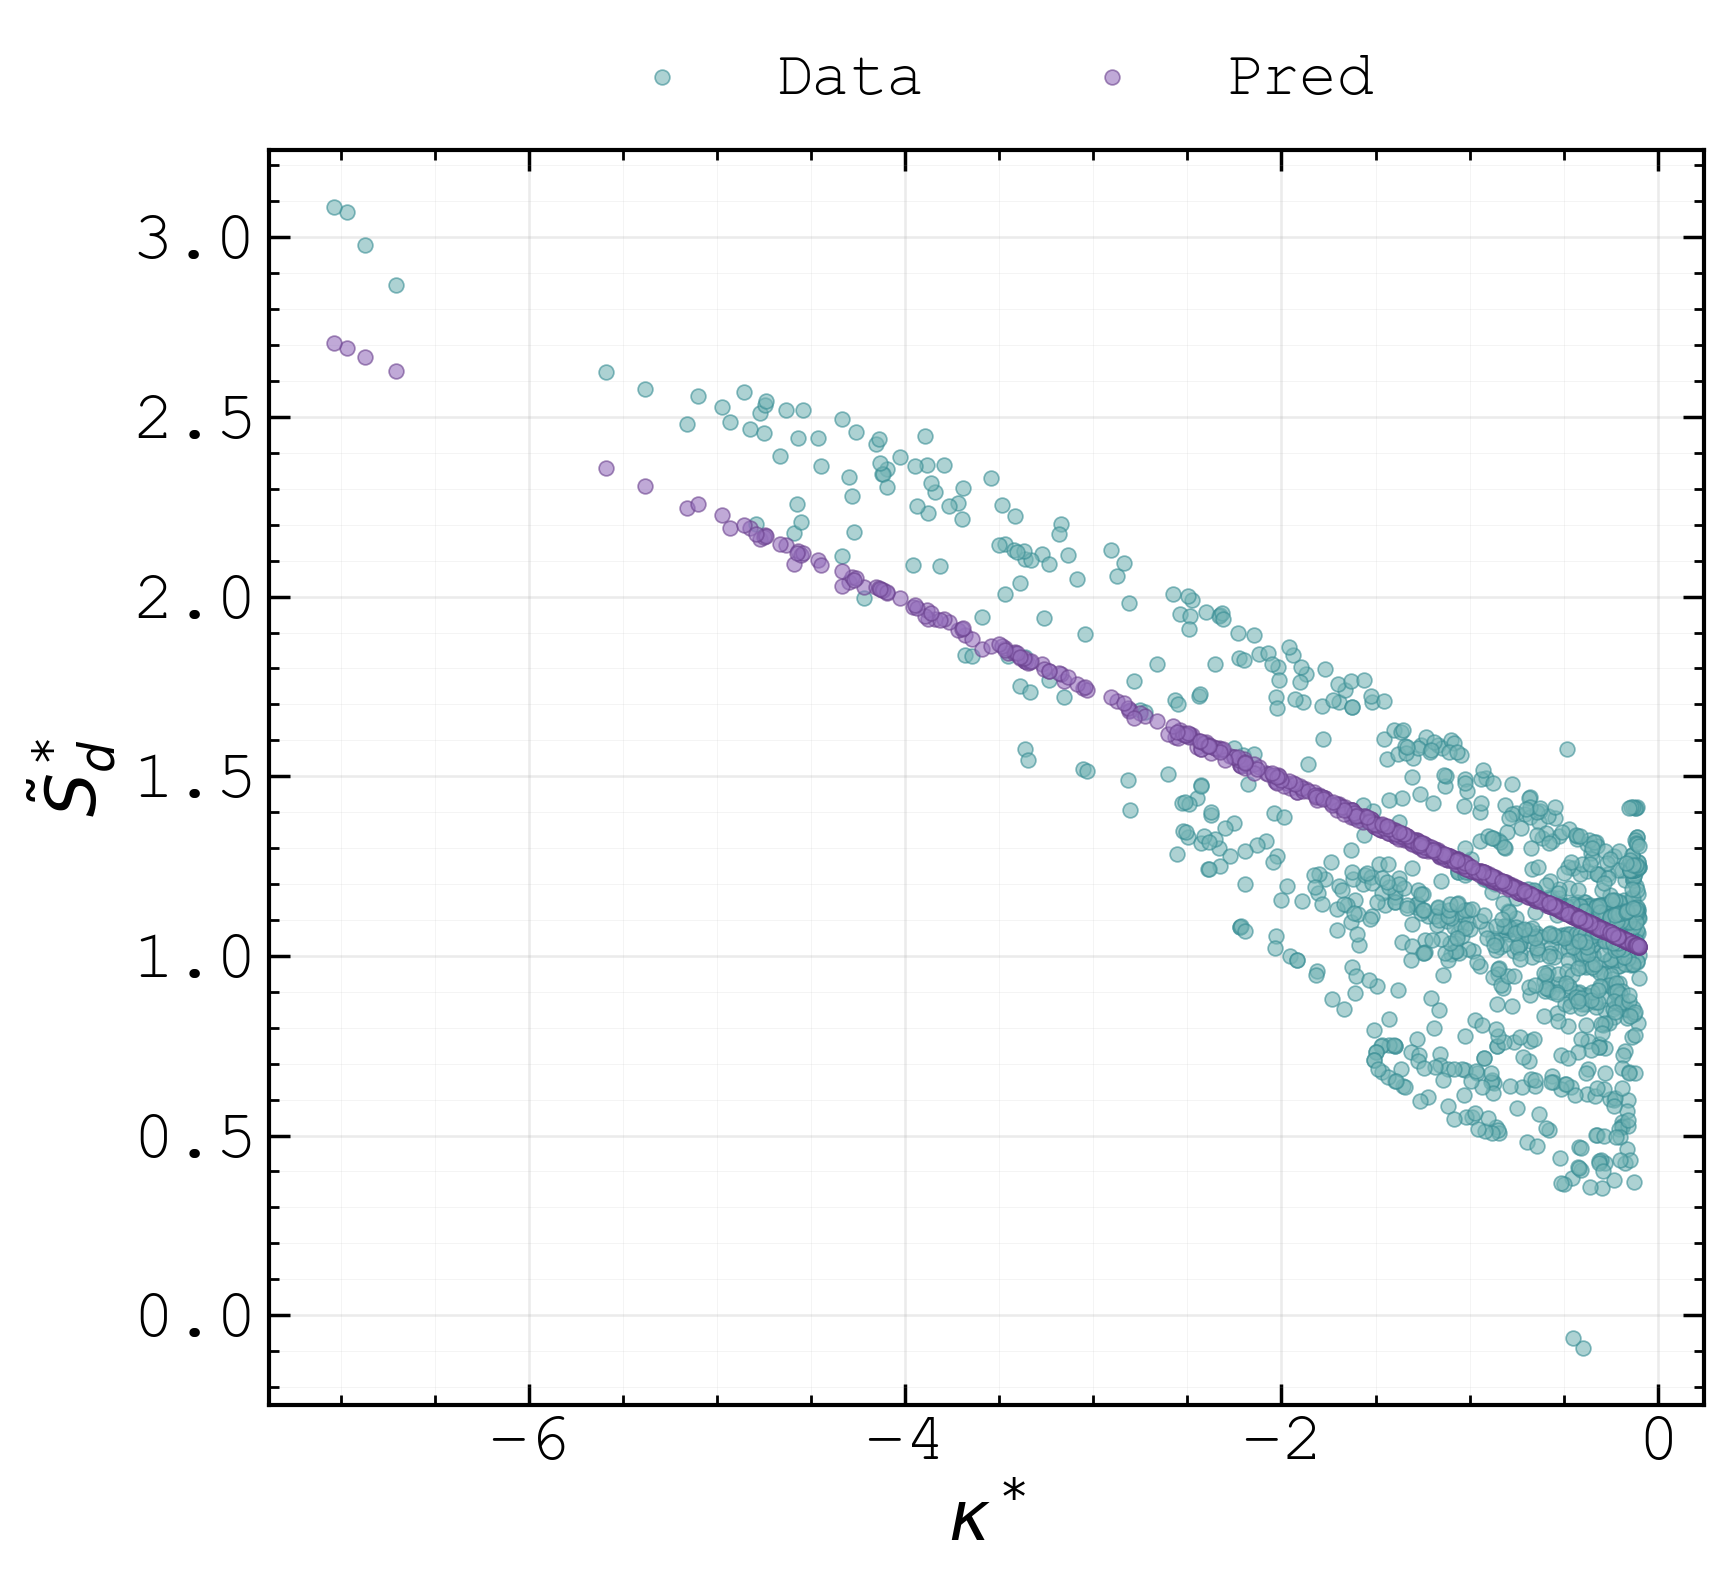

In [10]:
# Negative-curvature fit diagnostics (no stretch-rate plots)
import matplotlib.pyplot as plt

SAVE_NEG_FIT_PLOTS = True
NEG_FIT_OUT_DIR = "fit_plots"
DIAG_SCATTER_S = 18
DIAG_ALPHA = 0.6
LINE_WIDTH = 2.2
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)

def plot_negative_fit_diagnostics(
    df: pd.DataFrame,
    y_pred: np.ndarray,
    savepath: Path | None = None,
) -> None:
    y_true = df[TARGET_COLUMN].to_numpy()

    # (1) Predicted vs true
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        y_true,
        y_pred,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    lim_min = float(min(y_true.min(), y_pred.min()))
    lim_max = float(max(y_true.max(), y_pred.max()))
    ax.plot(
        [lim_min, lim_max],
        [lim_min, lim_max],
        linestyle="--",
        color=COLOR_LINE,
        linewidth=LINE_WIDTH,
        label="1:1",
    )
    ax.set_xlabel(f"{LABEL_SD} (true)")
    ax.set_ylabel(f"{LABEL_SD} (pred)")
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax, equal=True)
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        save_multi_fig(fig, savepath, "pred_vs_true")
    plt.show()
    plt.close(fig)

    # (2) Sd vs curvature with predictions at data points
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        df[CURVATURE_COLUMN],
        y_true,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    ax.scatter(
        df[CURVATURE_COLUMN],
        y_pred,
        s=DIAG_SCATTER_S,
        alpha=DIAG_ALPHA,
        color=COLOR_PRED,
        edgecolors=COLOR_PRED_EDGE,
        linewidths=0.5,
        label="Pred",
    )
    ax.set_xlabel(LABEL_CURV)
    ax.set_ylabel(LABEL_SD)
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax)
    if savepath is not None:
        save_multi_fig(fig, savepath, "sd_vs_curvature")
    plt.show()
    plt.close(fig)

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, TEMP_COLUMN, THERMAL_DIFF_COLUMN, S_L_COLUMN, L_REF_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()

        _, y_pred, _, _ = fit_c_constant(neg_df)
        savepath = None
        if SAVE_NEG_FIT_PLOTS:
            out_dir = case_out_dir(t, c_val, NEG_FIT_OUT_DIR)
            savepath = out_dir / "neg_fit_diagnostics"

        plot_negative_fit_diagnostics(
            neg_df,
            y_pred=y_pred,
            savepath=savepath,
        )







### Negative-curvature posterior bands


t=200, T=0.60: C=-3.923e-01, std_m=4.523e-01, noise_var=8.632e+01


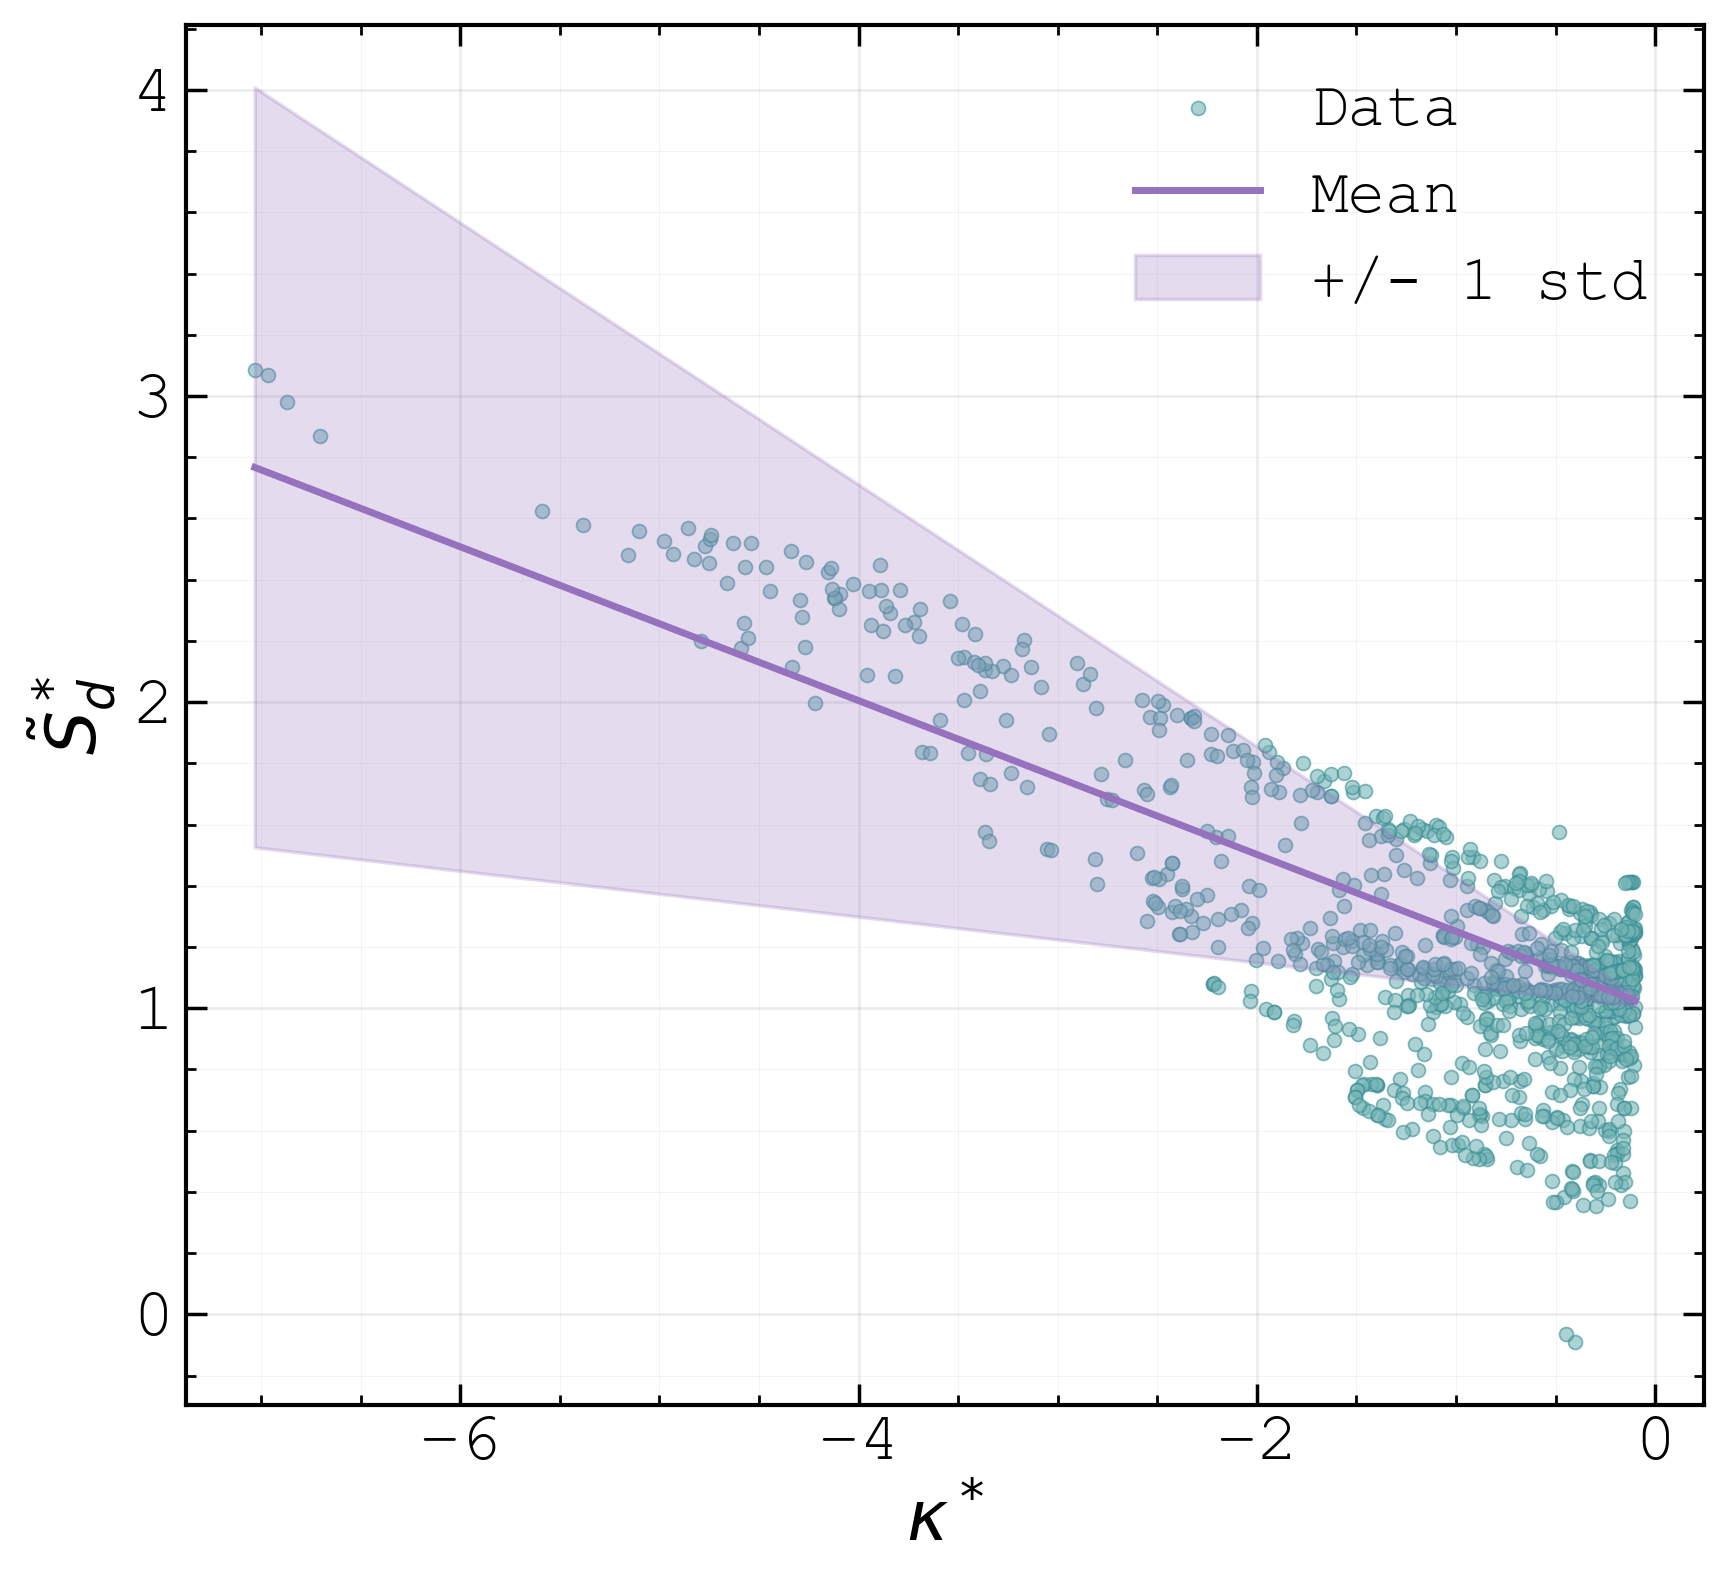

In [11]:
# Posterior bands for the negative-curvature model
import matplotlib.pyplot as plt

NEG_SAVE_POSTERIOR_PLOTS = True
NEG_POSTERIOR_OUT_DIR = "posterior_plots"
NEG_SCATTER_S = 16
NEG_ALPHA = 0.6
NEG_BAND_ALPHA = 0.25
NEG_LINE_WIDTH = 2.0

def bayes_posterior_scalar(
    a: np.ndarray,
    y: np.ndarray,
    prior_alpha: float,
) -> tuple[float, float, float]:
    n = len(y)
    ata = float((a * a).sum())
    aty = float((a * y).sum())
    if ata <= 0.0:
        raise ValueError("Invalid posterior: zero denominator")
    m_hat = aty / ata
    resid = y - a * m_hat
    noise_var = float(np.var(resid, ddof=max(n - 1, 1)))
    if noise_var <= 0.0 or not np.isfinite(noise_var):
        noise_var = 1e-12
    post_prec = prior_alpha + ata / noise_var
    post_var = 1.0 / post_prec
    post_mean = post_var * (aty / noise_var)
    return post_mean, post_var, noise_var

def sample_scalar(
    mean: float,
    var: float,
    n_samples: int,
    rng: np.random.Generator,
) -> np.ndarray:
    return rng.normal(mean, np.sqrt(var), size=n_samples)

def plot_neg_band(
    x: np.ndarray,
    y_mean: np.ndarray,
    y_std: np.ndarray,
    x_label: str,
    y_label: str,
    data_x: np.ndarray | None = None,
    data_y: np.ndarray | None = None,
    savepath: Path | None = None,
) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    if data_x is not None and data_y is not None:
        ax.scatter(
            data_x,
            data_y,
            s=NEG_SCATTER_S,
            alpha=NEG_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
    ax.plot(
        x,
        y_mean,
        color=COLOR_PRED,
        linewidth=NEG_LINE_WIDTH,
        label="Mean",
    )
    ax.fill_between(
        x,
        y_mean - BAND_SIGMA * y_std,
        y_mean + BAND_SIGMA * y_std,
        color=COLOR_PRED,
        alpha=NEG_BAND_ALPHA,
        label=f"+/- {BAND_SIGMA:g} std",
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(frameon=False, fontsize=PLOT_FONT_SIZE - 2)
    style_axes(ax)
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        save_multi_fig(fig, savepath, "band")
    plt.show()
    plt.close(fig)

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [
            CURVATURE_COLUMN,
            TEMP_COLUMN,
            THERMAL_DIFF_COLUMN,
            S_L_COLUMN,
            L_REF_COLUMN,
            TARGET_COLUMN,
        ]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()
        if len(neg_df) < 5:
            print(
                f"t={t}, T={float(c_val):.2f}: insufficient data for negative posterior (n={len(neg_df)})"
            )
            continue

        seed = POSTERIOR_SEED + int(t) * 1000 + int(float(c_val) * 100) + 50000
        rng = np.random.default_rng(seed)

        temp = neg_df[TEMP_COLUMN].to_numpy()
        curv = neg_df[CURVATURE_COLUMN].to_numpy()
        alpha = neg_df[THERMAL_DIFF_COLUMN].to_numpy()
        s_l = float(neg_df[S_L_COLUMN].iloc[0])
        l_ref = float(neg_df[L_REF_COLUMN].iloc[0])
        denom = temp * s_l * l_ref
        a = (curv * alpha) / denom
        y_true = neg_df[TARGET_COLUMN].to_numpy()
        y_fit = 1.0 - y_true

        post_mean, post_var, noise_var = bayes_posterior_scalar(
            a,
            y_fit,
            prior_alpha=PRIOR_ALPHA,
        )
        m_samples = sample_scalar(post_mean, post_var, N_POST_SAMPLES, rng)
        c_mean = post_mean - 1.0

        print(
            f"t={t}, T={float(c_val):.2f}: "
            f"C={c_mean:.3e}, std_m={np.sqrt(post_var):.3e}, "
            f"noise_var={noise_var:.3e}"
        )

        plot_df = neg_df
        if len(plot_df) > MAX_POINTS_FOR_BAND:
            plot_df = plot_df.sample(MAX_POINTS_FOR_BAND, random_state=seed)

        curv_data = plot_df[CURVATURE_COLUMN].to_numpy()
        sd_data = plot_df[TARGET_COLUMN].to_numpy()

        curv_grid = np.linspace(float(curv.min()), float(curv.max()), 120)
        temp_med = float(np.median(temp))
        alpha_med = float(np.median(alpha))
        a_grid = (curv_grid * alpha_med) / (temp_med * s_l * l_ref)
        sd_samples = 1.0 - a_grid[:, None] * m_samples[None, :]
        sd_mean = sd_samples.mean(axis=1)
        sd_std = sd_samples.std(axis=1)

        savepath = None
        if NEG_SAVE_POSTERIOR_PLOTS:
            out_dir = case_out_dir(t, c_val, NEG_POSTERIOR_OUT_DIR)
            savepath = out_dir / "sd_vs_curvature_posterior_neg"

        plot_neg_band(
            curv_grid,
            sd_mean,
            sd_std,
            x_label=LABEL_CURV,
            y_label=LABEL_SD,
            data_x=curv_data,
            data_y=sd_data,
            savepath=savepath,
        )


In [12]:
# 3D interactive plot: curvature vs stretch rate vs Sd with fitted surface
import plotly.graph_objects as go

SAVE_PLOTLY_HTML = True
PLOTLY_OUT_DIR = "fit_plots"
MAX_PLOT_POINTS = 20000
SURFACE_N = 60

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()
        if len(pos_df) < 3:
            print(f"t={t}, T={float(c_val):.2f}: insufficient positive-curvature data for surface")
            continue

        l_curv, l_str, r2, _ = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )

        if len(pos_df) > MAX_PLOT_POINTS:
            pos_df = pos_df.sample(MAX_PLOT_POINTS, random_state=42)
        if len(neg_df) > MAX_PLOT_POINTS:
            neg_df = neg_df.sample(MAX_PLOT_POINTS, random_state=42)

        curv = pos_df[CURVATURE_COLUMN].to_numpy()
        stretch = pos_df[STRETCH_COLUMN].to_numpy()
        sd = pos_df[TARGET_COLUMN].to_numpy()

        curv_min, curv_max = float(curv.min()), float(curv.max())
        stretch_min, stretch_max = float(stretch.min()), float(stretch.max())
        curv_grid = np.linspace(curv_min, curv_max, SURFACE_N)
        stretch_grid = np.linspace(stretch_min, stretch_max, SURFACE_N)
        curv_mesh, stretch_mesh = np.meshgrid(curv_grid, stretch_grid)
        sd_mesh = 1.0 - l_curv * curv_mesh - l_str * stretch_mesh

        fig = go.Figure()
        fig.add_trace(
            go.Scatter3d(
                x=curv,
                y=stretch,
                z=sd,
                mode="markers",
                marker=dict(
                    size=2,
                    color=COLOR_DATA,
                    opacity=0.7,
                    line=dict(color=COLOR_DATA_EDGE, width=0.5),
                ),
                name="Data (pos)",
            )
        )
        if len(neg_df) > 0:
            fig.add_trace(
                go.Scatter3d(
                    x=neg_df[CURVATURE_COLUMN].to_numpy(),
                    y=neg_df[STRETCH_COLUMN].to_numpy(),
                    z=neg_df[TARGET_COLUMN].to_numpy(),
                    mode="markers",
                    marker=dict(
                        size=2,
                        color=COLOR_NEUTRAL,
                        opacity=0.7,
                        line=dict(color=COLOR_LINE, width=0.5),
                    ),
                    name="Data (neg)",
                )
            )
        fig.add_trace(
            go.Surface(
                x=curv_mesh,
                y=stretch_mesh,
                z=sd_mesh,
                showscale=False,
                opacity=0.5,
                colorscale=[[0, COLOR_PRED], [1, COLOR_PRED]],
                name="Fit surface",
            )
        )

        fig.update_layout(
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




